<a href="https://colab.research.google.com/github/Riccogao/datasci_223/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

# load data
df = pd.read_excel('/content/drive/My Drive/data1.xlsx')

# check basic structure of the dataset
print(df.info())
print(df.shape)
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idi                 872 non-null    int64  
 1   ID                  872 non-null    int64  
 2   first_author        872 non-null    object 
 3   group               872 non-null    object 
 4   data_start          872 non-null    int64  
 5   data_finish         872 non-null    object 
 6   country             872 non-null    object 
 7   country_additional  70 non-null     object 
 8   site_general        872 non-null    object 
 9   site_specific       872 non-null    object 
 10  diagnosis_details   117 non-null    object 
 11  females             872 non-null    object 
 12  age                 872 non-null    object 
 13  diagnosis           872 non-null    object 
 14  first_treatment     465 non-null    object 
 15  TI                  872 non-null    int64  
 16  tN      

The data source is from a systematic review and meta-analysis study named "The patient, diagnostic, and treatment intervals in adult patients with cancer from high and lower-income countries: a systematic review and meta-analysis" which can be downloaded from the Open Science Framework: DOI 10.17605/OSF.IO/REY9C (https://osf.io/rey9c/).

Overview of the research question and design:

1.   The main research question in this paper
is trying to understand the health disparities among adult patients with different types of cancer in high-income and lower-income countries, with a focus on comparing the duration of the patient, diagnostic, and treatment intervals.
2.   The following data analysis is play around with the filtered dataset containing only breast cancer data from the original dataset. As breast cancer is one of the mose common cancers and a leading cause of cancer-related deaths among women worldwide. Investigating the intervals of patient, diagnostic, and treatment between high-income and lower-income countries can potentially identify health disparities, address delays, and improve breast cancer outcomes globally





In [7]:

# Filter the DataFrame to keep only rows where 'site_general' equals 'breast'
breast_df = df[(df['site_specific'].isin(['PA breast', 'breast']))]
nonpa_breast_df = df[(df['site_specific'] == 'breast')]
pa_breast_df = df[(df['site_specific'] == 'PA breast')]

# check basic structure of the filtered dataset
print(breast_df.info())
print(breast_df.shape)
print(breast_df.columns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 871
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idi                 184 non-null    int64  
 1   ID                  184 non-null    int64  
 2   first_author        184 non-null    object 
 3   group               184 non-null    object 
 4   data_start          184 non-null    int64  
 5   data_finish         184 non-null    object 
 6   country             184 non-null    object 
 7   country_additional  6 non-null      object 
 8   site_general        184 non-null    object 
 9   site_specific       184 non-null    object 
 10  diagnosis_details   0 non-null      object 
 11  females             184 non-null    object 
 12  age                 184 non-null    object 
 13  diagnosis           184 non-null    object 
 14  first_treatment     99 non-null     object 
 15  TI                  184 non-null    int64  
 16  tN      

Description of the filtered dataset containing only breast cancer data:

*   Dimention: 60 colunmns with 178 observations

*   Input features:
      *   Study and population characteristics data
      *   Diagnostic and treatment data
      *   socioeconomic indicators

*   Outcomes:
    
      *   pmm (Patient interval in days): Time from symptom onset to first presentation
      *   pmd (Diagnostic interval in days): Time from first presentation to diagnosis
      *   pmt (Treatment interval in days): Time from diagnosis to start of treatment




In [62]:
#Relative contribution
import numpy as np
from scipy.stats import norm

#Define function
def ci_median_ws(alpha, y1, y2):
    z = norm.ppf(1 - alpha / 2)
    n = len(y1)
    med1 = np.median(y1)
    med2 = np.median(y2)

    # Calculation details omitted for brevity
    diff = y1 - y2
    se = np.std(diff, ddof=1) / np.sqrt(n)

    logratio = np.log(med1 / med2)
    ll = np.exp(logratio - z * se)
    ul = np.exp(logratio + z * se)

    return med1, med2, med1 / med2, ll, ul

breast_data = df[(df['site_specific'] == 'breast') &
                   (df['PI'] == 1) &
                   (df['DI'] == 1) &
                   (df['TI'] == 1)]
# Calculate pooled medians
patient_med = breast_data['pmm'].median()
diagnostic_med = breast_data['dmm'].median()
treatment_med = breast_data['tmm'].median()

# Calculate confidence intervals for ratios
di_pi_ci = ci_median_ws(0.05, breast_data['dmm'], breast_data['pmm'])
di_ti_ci = ci_median_ws(0.05, breast_data['dmm'], breast_data['tmm'])
pi_ti_ci = ci_median_ws(0.05, breast_data['pmm'], breast_data['tmm'])

results = pd.DataFrame({
    'Interval Ratio': ['Diagnostic/Patient', 'Diagnostic/Treatment', 'Patient/Treatment'],
    'Median 1': [di_pi_ci[0], di_ti_ci[0], pi_ti_ci[0]],
    'Median 2': [di_pi_ci[1], di_ti_ci[1], pi_ti_ci[2]],
    'Median Ratio': [di_pi_ci[2], di_ti_ci[2], pi_ti_ci[2]],
    'Lower Bound': [di_pi_ci[3], di_ti_ci[3], pi_ti_ci[3]],
    'Upper Bound': [di_pi_ci[4], di_ti_ci[4], pi_ti_ci[4]]
})

# Display the results table
print(results)


         Interval Ratio  Median 1   Median 2  Median Ratio   Lower Bound  \
0    Diagnostic/Patient      24.7  26.500000      0.932075  7.870688e-15   
1  Diagnostic/Treatment      24.7  25.500000      0.968627  5.661092e-07   
2     Patient/Treatment      26.5   1.039216      1.039216  5.576050e-12   

    Upper Bound  
0  1.103798e+14  
1  1.657346e+06  
2  1.936800e+11  




*   This code above is provided from the study but written in R. To sumarize, this code is to caculate the confidence interval for the ratio of two population (Breast not pregnancy-associated vs. Breast pregnancy-associated) medians from paired data.
*   Error encounutered while translation the R code "ValueError: operands could not be broadcast together with shapes (56,) (92,)" suggested that the two numpy arrays y1 and y2 have different length after filtered. To fix this issue, standard error (se) need to be adjusted as "se = np.std(y1-y2, ddof=1) / np.sqrt(n)" .




In [63]:

from scipy.stats import mannwhitneyu

# Define function to calculate the pooled median
def pool_med(df, coverage_prob=0.95):
    return np.median(df), np.quantile(df, [0.5 - coverage_prob/2, 0.5 + coverage_prob/2])

# ALL BREAST CANCER
# Patient interval
d1 = breast_df[breast_df['PI'] == 1]
print(f"Patient Interval - All Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['pN'].sum()}")
patient_med, patient_ci = pool_med(d1['pmm'])
print(f"Pooled Median: {patient_med}, 95% CI: {patient_ci}")

# stratified Meta-analysis and Wilcoxon Rank Sum Test
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()

if len(high_income) > 0 and len(lower_income) > 0:
    # Use Mann-Whitney U test for independent samples
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")
else:
    print("Not enough data in one of the groups.")

# Diagnostic interval
d1 = breast_df[breast_df['DI'] == 1]
print(f"\nDiagnostic Interval - All Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['dN'].sum()}")
diag_med, diag_ci = pool_med(d1['dmm'])
print(f"Pooled Median: {diag_med}, 95% CI: {diag_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    # Use Mann-Whitney U test for independent samples
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")
else:
    print("Not enough data in one of the groups.")


# Treatment interval
d1 = breast_df[breast_df['TI'] == 1]
print(f"\nTreatment Interval - All Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['tN'].sum()}")
treat_med, treat_ci = pool_med(d1['tmm'])
print(f"Pooled Median: {treat_med}, 95% CI: {treat_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# NON-Pregnancy associated BREAST CANCER
# Patient interval
d1 = nonpa_breast_df[nonpa_breast_df['PI'] == 1]
print(f"\nPatient Interval - Non-Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['pN'].sum()}")
patient_med, patient_ci = pool_med(d1['pmm'])
print(f"Pooled Median: {patient_med}, 95% CI: {patient_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# Diagnostic interval
d1 = nonpa_breast_df[nonpa_breast_df['DI'] == 1]
print(f"\nDiagnostic Interval - Non-Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['dN'].sum()}")
diag_med, diag_ci = pool_med(d1['dmm'])
print(f"Pooled Median: {diag_med}, 95% CI: {diag_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# Treatment interval
d1 = nonpa_breast_df[nonpa_breast_df['TI'] == 1]
print(f"\nTreatment Interval - Non-Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['tN'].sum()}")
treat_med, treat_ci = pool_med(d1['tmm'])
print(f"Pooled Median: {treat_med}, 95% CI: {treat_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# Pregnancy associated BREAST CANCER
# Patient interval
d1 = pa_breast_df[pa_breast_df['PI'] == 1]
print(f"\nPatient Interval - Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['pN'].sum()}")
patient_med, patient_ci = pool_med(d1['pmm'])
print(f"Pooled Median: {patient_med}, 95% CI: {patient_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# Diagnostic interval
d1 = pa_breast_df[pa_breast_df['DI'] == 1]
print(f"\nDiagnostic Interval - Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['dN'].sum()}")
diag_med, diag_ci = pool_med(d1['dmm'])
print(f"Pooled Median: {diag_med}, 95% CI: {diag_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

# Treatment interval
d1 = pa_breast_df[pa_breast_df['TI'] == 1]
print(f"\nTreatment Interval - Pregnancy Associated Breast Cancer\nNumber of studies: {d1.shape[0]}, Total N: {d1['tN'].sum()}")
treat_med, treat_ci = pool_med(d1['tmm'])
print(f"Pooled Median: {treat_med}, 95% CI: {treat_ci}")
high_income = d1[d1['GNIG'] == 'high']['pmm'].dropna()
lower_income = d1[d1['GNIG'] == 'lower']['pmm'].dropna()
if len(high_income) > 0 and len(lower_income) > 0:
    stat, pval = mannwhitneyu(high_income, lower_income, alternative='two-sided')
    print(f"Mann-Whitney U Test (High vs Lower Income): Statistic={stat}, p-value={pval}")

Patient Interval - All Breast Cancer
Number of studies: 93, Total N: 24957.0
Pooled Median: 42.699999999999996, 95% CI: [  7.   382.08]
Mann-Whitney U Test (High vs Lower Income): Statistic=518.0, p-value=0.0025414160350378497

Diagnostic Interval - All Breast Cancer
Number of studies: 56, Total N: 95053.0
Pooled Median: 24.5, 95% CI: [  3.125 148.125]
Mann-Whitney U Test (High vs Lower Income): Statistic=105.0, p-value=0.33924858997909046

Treatment Interval - All Breast Cancer
Number of studies: 99, Total N: 1709349.0240000002
Pooled Median: 29.0, 95% CI: [ 9.25 66.3 ]
Mann-Whitney U Test (High vs Lower Income): Statistic=70.5, p-value=0.3530624679337754

Patient Interval - Non-Pregnancy Associated Breast Cancer
Number of studies: 87, Total N: 24812.0
Pooled Median: 42.14, 95% CI: [  7.   386.04]
Mann-Whitney U Test (High vs Lower Income): Statistic=403.5, p-value=0.0023838186537247586

Diagnostic Interval - Non-Pregnancy Associated Breast Cancer
Number of studies: 51, Total N: 94808



*   This code above is provided from the study but written in R. To sumarize, this code is to analyze and compare the intervals of different stages of breast cancer diagnosis and treatment, assessing whether there are significant differences based on income levels and potentially other factors, across all countries included in the dataset.
*   The error "ValueError: The samples x and y must have the same length" occurs because the higher_income and lower_income have different number of observations after filtered and the wilcoxon function expects two datasets of equal length when comparing paired samples.
*   Since the nature of the data is not paired,"Records after filtering: 93, High-income records: 26, Lower-income records: 67". The groups should be considered independent rather than paired, sothe Mann-Whitney U test was used to compare the high-income and lower-income groups.








In [37]:
#Intervals HIC
#patient interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['PI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval:")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")
#diagnostic interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['DI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval:")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")
# Treatment interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['TI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['tN'].sum())
treatment_med, treatment_ci = pool_med(d1['tmm'])
print("Pooled Median - Treatment Interval:")
print(f"Median: {treatment_med}, 95% CI: {treatment_ci}")

#NON-Pregnancy associated BREAST CANCER
#patient interval
d1 = df[(df['site_specific'] == 'breast') & (df['PI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval (Non-Pregnancy associated BREAST CANCER):")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")
#diagnostic interval
d1 = df[(df['site_specific'] == 'breast') & (df['DI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval (Non-Pregnancy associated BREAST CANCER):")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")

#Treatment interval
d1 = df[(df['site_specific'] == 'breast') & (df['TI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['tN'].sum())
treatment_med, treatment_ci = pool_med(d1['tmm'])
print("Pooled Median - Treatment Interval (Non-Pregnancy associated BREAST CANCER):")
print(f"Median: {treatment_med}, 95% CI: {treatment_ci}")

#Pregnancy associated BREAST CANCER
#patient interval
d1 = df[(df['site_specific'] == 'PA breast') & (df['PI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval (Pregnancy associated BREAST CANCER):")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")

#diagnostic interval
d1 = df[(df['site_specific'] == 'PA breast') & (df['DI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval (Pregnancy associated BREAST CANCER):")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")

#Treatment interval
d1 = df[(df['site_specific'] == 'PA breast') & (df['TI'] == 1) & (df['GNI'] == 'high')]
print(d1.shape)
print(d1['tN'].sum())
treatment_med, treatment_ci = pool_med(d1['tmm'])
print("Pooled Median - Treatment Interval (Pregnancy associated BREAST CANCER):")
print(f"Median: {treatment_med}, 95% CI: {treatment_ci}")


(26, 60)
6911.0
Pooled Median - Patient Interval:
Median: 31.939999999999998, 95% CI: (6.625000000000001, 99.6875)
(30, 60)
87053.0
Pooled Median - Diagnostic Interval:
Median: 19.0, 95% CI: (1.7250000000000005, 46.77499999999997)
(70, 60)
1698176.024
Pooled Median - Treatment Interval:
Median: 29.5, 95% CI: (10.625000000000007, 47.64999999999995)
(22, 60)
6798.0
Pooled Median - Patient Interval (Non-Pregnancy associated BREAST CANCER):
Median: 28.5, 95% CI: (6.525, 102.93749999999993)
(26, 60)
86820.0
Pooled Median - Diagnostic Interval (Non-Pregnancy associated BREAST CANCER):
Median: 21.0, 95% CI: (5.625000000000001, 48.875)
(66, 60)
1697943.0239999997
Pooled Median - Treatment Interval (Non-Pregnancy associated BREAST CANCER):
Median: 30.85, 95% CI: (10.125000000000007, 48.25)
(4, 60)
113.0
Pooled Median - Patient Interval (Pregnancy associated BREAST CANCER):
Median: 48.0, 95% CI: (30.375, 61.0)
(4, 60)
233.0
Pooled Median - Diagnostic Interval (Pregnancy associated BREAST CANCER)

In [44]:
#Intervals LIC
#patient interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['PI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval (Intervals LIC):")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")

#diagnostic interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['DI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval (Intervals LIC):")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")

#treatment interval
d1 = df[(df['site_specific'].isin(['PA breast', 'breast'])) & (df['TI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['tN'].sum())
treatment_med, treatment_ci = pool_med(d1['tmm'])
print("Pooled Median - Treatment Interval (Intervals LIC):")
print(f"Median: {treatment_med}, 95% CI: {treatment_ci}")


#NON-Pregnancy associated BREAST CANCER
#patient interval
d1 = df[(df['site_specific'] == 'breast') & (df['PI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval (NON-Pregnancy associated BREAST CANCER):")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")

#diagnostic interval
d1 = df[(df['site_specific'] == 'breast') & (df['DI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval (NON-Pregnancy associated BREAST CANCER):")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")

#Treatment interval
d1 = df[(df['site_specific'] == 'breast') & (df['TI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['tN'].sum())
treatment_med, treatment_ci = pool_med(d1['tmm'])
print("Pooled Median - Treatment Interval (NON-Pregnancy associated BREAST CANCER):")
print(f"Median: {treatment_med}, 95% CI: {treatment_ci}")


#Pregnancy associated BREAST CANCER
#patient interval
d1 = df[(df['site_specific'] == 'PA breast') & (df['PI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['pN'].sum())
patient_med, patient_ci = pool_med(d1['pmm'])
print("Pooled Median - Patient Interval (Pregnancy associated BREAST CANCER):")
print(f"Median: {patient_med}, 95% CI: {patient_ci}")

#diagnostic interval
d1 = df[(df['site_specific'] == 'PA breast') & (df['DI'] == 1) & (df['GNIG'] == 'lower')]
print(d1.shape)
print(d1['dN'].sum())
diagnostic_med, diagnostic_ci = pool_med(d1['dmm'])
print("Pooled Median - Diagnostic Interval (Pregnancy associated BREAST CANCER):")
print(f"Median: {diagnostic_med}, 95% CI: {diagnostic_ci}")


(67, 60)
18046.0
Pooled Median - Patient Interval (Intervals LIC):
Median: 58.0, 95% CI: (9.0, 393.04499999999996)
(26, 60)
8000.0
Pooled Median - Diagnostic Interval (Intervals LIC):
Median: 55.0, 95% CI: (11.625000000000005, 173.25)
(29, 60)
11173.0
Pooled Median - Treatment Interval (Intervals LIC):
Median: 28.0, 95% CI: (10.970000000000006, 102.30000000000007)
(65, 60)
18014.0
Pooled Median - Patient Interval (NON-Pregnancy associated BREAST CANCER):
Median: 50.0, 95% CI: (9.0, 393.47999999999996)
(25, 60)
7988.0
Pooled Median - Diagnostic Interval (NON-Pregnancy associated BREAST CANCER):
Median: 53.0, 95% CI: (11.400000000000006, 147.0)
(29, 60)
11173.0
Pooled Median - Treatment Interval (NON-Pregnancy associated BREAST CANCER):
Median: 28.0, 95% CI: (10.970000000000006, 102.30000000000007)
(2, 60)
32.0
Pooled Median - Patient Interval (Pregnancy associated BREAST CANCER):
Median: 195.5, 95% CI: (113.325, 277.675)
(1, 60)
12.0
Pooled Median - Diagnostic Interval (Pregnancy associ

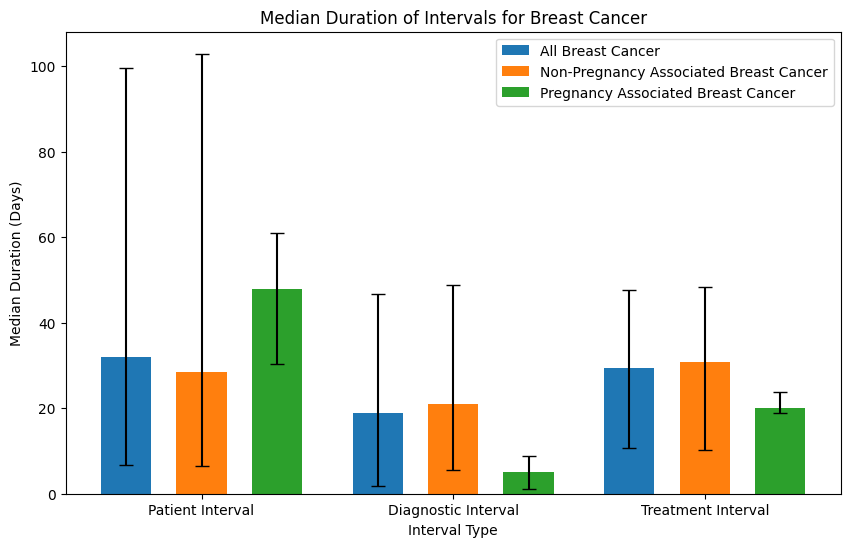

In [24]:
import matplotlib.pyplot as plt


# Create a list of labels for the x-axis
labels = ['Patient Interval', 'Diagnostic Interval', 'Treatment Interval']

# Create lists for the medians and confidence intervals for all breast cancer
all_medians = [31.94, 19.0, 29.5]
all_lower_cis = [6.625, 1.725, 10.625]
all_upper_cis = [99.6875, 46.775, 47.65]

# Create lists for the medians and confidence intervals for non-pregnancy associated breast cancer
non_pa_medians = [28.5, 21.0, 30.85]
non_pa_lower_cis = [6.525, 5.625, 10.125]
non_pa_upper_cis = [102.9375, 48.875, 48.25]

# Create lists for the medians and confidence intervals for pregnancy associated breast cancer
pa_medians = [48.0, 5.0, 20.0]
pa_lower_cis = [30.375, 1.075, 19.0]
pa_upper_cis = [61.0, 8.925, 23.775]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot for all breast cancer
x = np.arange(len(labels))
plt.bar(x - 0.3, all_medians, yerr=[np.array(all_medians) - np.array(all_lower_cis), np.array(all_upper_cis) - np.array(all_medians)], capsize=5, label='All Breast Cancer', width=0.2)

# Create the bar plot for non-pregnancy associated breast cancer
plt.bar(x, non_pa_medians, yerr=[np.array(non_pa_medians) - np.array(non_pa_lower_cis), np.array(non_pa_upper_cis) - np.array(non_pa_medians)], capsize=5, label='Non-Pregnancy Associated Breast Cancer', width=0.2)

# Create the bar plot for pregnancy associated breast cancer
plt.bar(x + 0.3, pa_medians, yerr=[np.array(pa_medians) - np.array(pa_lower_cis), np.array(pa_upper_cis) - np.array(pa_medians)], capsize=5, label='Pregnancy Associated Breast Cancer', width=0.2)

# Set the x-axis tick labels
plt.xticks(x, labels)

# Add labels and title
plt.xlabel('Interval Type')
plt.ylabel('Median Duration (Days)')
plt.title('Median Duration of Intervals for Breast Cancer')
plt.legend()

# Show the plot
plt.show()


No valid records for the filtering senario that Pregnancy associated BREAST CANCER in treatment interval

In [43]:
#Treatment interval
# Check how many records match the conditions individually
print("Records with 'PA breast':", df[df['site_specific'] == 'PA breast'].shape[0])
print("Records where 'TI' is 1:", df[df['TI'] == 1].shape[0])
print("Records with 'GNIG' as 'lower':", df[df['GNIG'] == 'lower'].shape[0])

# Check how many records meet all conditions
print("Records meeting all conditions:", df[(df['site_specific'] == 'PA breast') & (df['TI'] == 1) & (df['GNIG'] == 'lower')].shape[0])



Records with 'PA breast': 6
Records where 'TI' is 1: 465
Records with 'GNIG' as 'lower': 179
Records meeting all conditions: 0


Research Question: How do the patient, diagnostic, and treatment intervals for breast cancer vary across different income levels (high-income vs. lower-income countries), and what factors contribute to these differences?

*   Dependent Variables:
      Patient Interval Duration (e.g., pmm)
      Diagnostic Interval Duration (e.g., dmm)
      Treatment Interval Duration (e.g., tmm)

*   Independent Variables:
      GNI group (high-income vs. lower-income)

*   Additional other relevant variables that may influence the interval durations:
      Demographic factors
      Clinical factors
      Healthcare system factors
      Socioeconomic factors

*   Model Selection: Ridge (L2 regularization) and Lasso (L1 regularization)
    *   Since the dataset is small after filtered from the original data, ridge and lasso regression model is used to help prevent overfitting by penalizing large coefficients in linear regression models.
    *   The Normality Assumption test shows a very small p-value (P<0.01) which suggest that the residuals are normally distributed.
    *   The Levene's test result shows a p-value of 0.0036 which indicated the homogeneity of variances assumption for the linear regression model is violated.
    







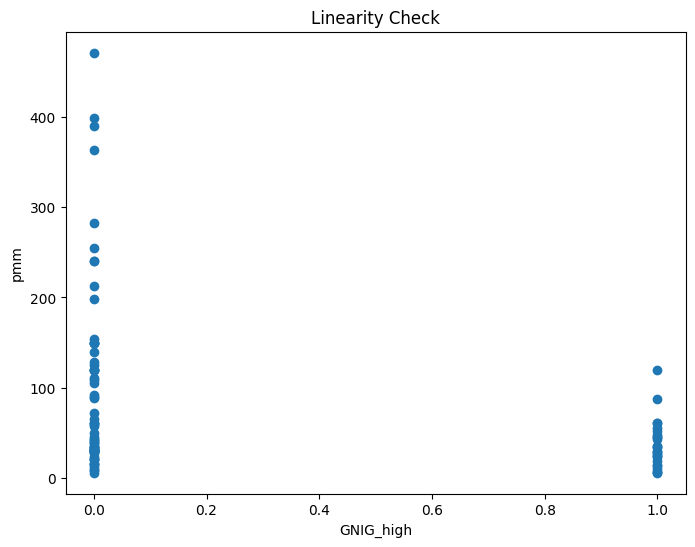

Normality Test (Anderson-Darling):
(5.141419785404267, 8.418977269699606e-13)


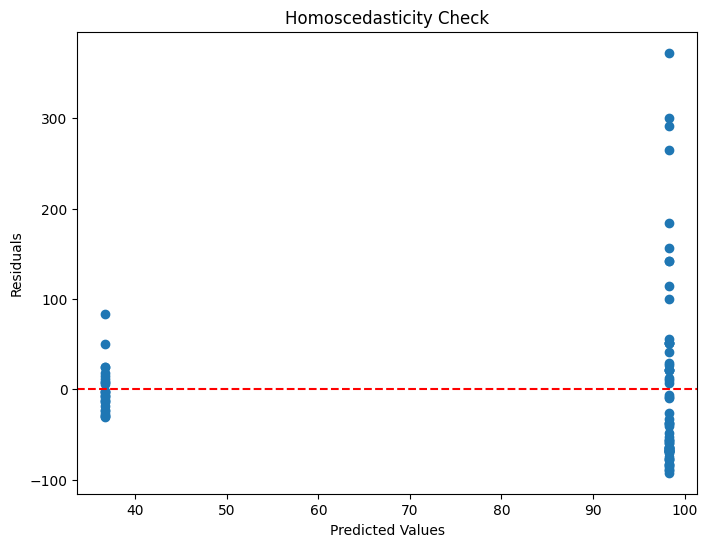

Levene's Test for Homogeneity of Variances:
LeveneResult(statistic=8.92878735705624, pvalue=0.0036082516487118063)


In [15]:

from scipy.stats import shapiro, levene
from sklearn.linear_model import LinearRegression

# Load data
d1 = breast_df[breast_df['PI'] == 1]
d1 = d1[['pmm', 'GNIG']].dropna()

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Split data into predictor and target outcomes
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['pmm'].values

# Linearity Assumption
plt.figure(figsize=(8, 6))
plt.scatter(X, y)
plt.xlabel('GNIG_high')
plt.ylabel('pmm')
plt.title('Linearity Check')
plt.show()

# Normality Assumption
from statsmodels.stats.diagnostic import normal_ad
linreg = LinearRegression()
linreg.fit(X, y)
residuals = y - linreg.predict(X)
print('Normality Test (Anderson-Darling):')
print(normal_ad(residuals))

# Homoscedasticity Assumption
plt.figure(figsize=(8, 6))
plt.scatter(linreg.predict(X), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.show()

# Levene's Test for Homogeneity of Variances
groups = np.unique(X)
residuals_grouped = [residuals[X.flatten() == group] for group in groups]
print('Levene\'s Test for Homogeneity of Variances:')
print(levene(*residuals_grouped))

In [16]:

from sklearn.linear_model import HuberRegressor

# Load data
d1 = breast_df[breast_df['PI'] == 1]
d1 = d1[['pmm', 'GNIG']].dropna()

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Split data into predictor and target variables
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['pmm'].values

# Huber Regression
huber = HuberRegressor()
huber.fit(X, y)
print("Huber Regression:")
print(f"Coefficients: {huber.coef_}")
print(f"Intercept: {huber.intercept_}")

Huber Regression:
Coefficients: [-31.78979443]
Intercept: 66.95176263962615


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huber Regression
huber = HuberRegressor()
huber.fit(X_train, y_train)

# Linear Regression with Log Transformation
linreg = LinearRegression()
linreg.fit(X_train, np.log(y_train))

# Huber Regression
y_pred_huber = huber.predict(X_test)
print("Huber Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_huber):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_huber):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_huber):.2f}")

# Linear Regression with Log Transformation
y_pred_linreg = np.exp(linreg.predict(X_test))  # Reverse log transformation for predictions
print("\nLinear Regression with Log Transformation:")
print(f"R-squared: {r2_score(y_test, y_pred_linreg):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_linreg):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_linreg):.2f}")

Huber Regression:
R-squared: -0.24
MSE: 25323.08
MAE: 106.87

Linear Regression with Log Transformation:
R-squared: -0.27
MSE: 26009.31
MAE: 108.15


In [18]:

from scipy.stats import mannwhitneyu
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression for Patient Interval
# All Breast Cancer
d1 = breast_df[breast_df['PI'] == 1]
d1 = d1[['pmm', 'GNIG']].dropna()  # Drop rows with missing values

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Fit Ridge regression model
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['pmm'].values
ridge = Ridge(alpha=0.1)  # Alpha controls the regularization strength
ridge.fit(X, y)
print(f"Ridge Regression for Patient Interval: Coefficients={ridge.coef_}, Intercept={ridge.intercept_}")

# Lasso Regression for Diagnostic Interval
# All Breast Cancer
d1 = breast_df[breast_df['DI'] == 1]
d1 = d1[['dmm', 'GNIG']].dropna()  # Drop rows with missing values

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Fit Lasso regression model
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['dmm'].values
lasso = Lasso(alpha=0.1)  # Alpha controls the regularization strength
lasso.fit(X, y)
print(f"Lasso Regression for Diagnostic Interval: Coefficients={lasso.coef_}, Intercept={lasso.intercept_}")

# Ridge Regression for Treatment Interval
# All Breast Cancer
d1 = breast_df[breast_df['TI'] == 1]
d1 = d1[['tmm', 'GNIG']].dropna()  # Drop rows with missing values

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Fit Ridge regression model
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['tmm'].values
ridge = Ridge(alpha=0.1)  # Alpha controls the regularization strength
ridge.fit(X, y)
print(f"Ridge Regression for Treatment Interval: Coefficients={ridge.coef_}, Intercept={ridge.intercept_}")

Ridge Regression for Patient Interval: Coefficients=[-61.22246331], Intercept=98.21101124878662
Lasso Regression for Diagnostic Interval: Coefficients=[-48.02897436], Intercept=67.24230769230768
Ridge Regression for Treatment Interval: Coefficients=[-7.65711064], Intercept=37.05290651502525


Result interpretation:


1.   Ridge Regression for Patient Interval: on average, the patient interval duration is shorter by approximately 61 days in high-income countries compared to lower-income countries, after accounting for regularization.
2.  Lasso Regression for Diagnostic Interval: the difference in diagnostic interval duration (in days) between high-income and lower-income countries i -48, suggest that the diagnostic interval duration is shorter by approximately 48 days in high-income countries compared to lower-income countries, after accounting for regularization.
3. Ridge Regression for Treatment Interval: on average, the treatment interval duration is shorter by approximately 8 days in high-income countries compared to lower-income countries, after accounting for regularization.



In [37]:

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load data
d1 = breast_df[breast_df['PI'] == 1]
d1 = d1[['pmm', 'GNIG']].dropna()

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Split data into train and test sets
X = d1['GNIG_high'].values.reshape(-1, 1)
y = d1['pmm'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
print("Linear Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_linreg):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_linreg):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_linreg):.2f}")

# Ridge Regression
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("\nRidge Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_ridge):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ridge):.2f}")

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("\nLasso Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_lasso):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")

Linear Regression:
R-squared: -0.11
MSE: 22723.76
MAE: 106.21

Ridge Regression:
R-squared: -0.11
MSE: 22730.68
MAE: 106.15

Lasso Regression:
R-squared: -0.11
MSE: 22733.79
MAE: 106.12


In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Load data
d1 = breast_df[breast_df['PI'] == 1]
d1 = d1[['pmm', 'GNIG']].dropna()

# Encode GNIG as a binary variable
d1['GNIG_high'] = d1['GNIG'].apply(lambda x: 1 if x == 'high' else 0)

# Split data into predictor and target variables
X = d1['GNIG_high'].values.reshape(-1, 1)
y = np.log(d1['pmm'].values)  # Apply logarithmic transformation

# Linear Regression
linreg = LinearRegression()
linreg.fit(X, y)
print("Linear Regression with Log Transformation:")
print(f"Coefficients: {linreg.coef_}")
print(f"Intercept: {linreg.intercept_}")

Linear Regression with Log Transformation:
Coefficients: [-0.75650387]
Intercept: 4.104732801895955


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingRegressor

#optimize the performance of the regression models

breast_df['age'] = pd.to_numeric(breast_df['age'], errors='coerce')  # Convert to numeric, coerce errors to NaN
breast_df['age_Squared'] = breast_df['age'] ** 2

#Regularization Parameter Tuning
# Define alpha values to search
alphas = [0.001, 0.01, 0.1, 1, 10]

# Create parameter grid
param_grid = {'alpha': alphas}

# Grid search for Ridge regression
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_grid.fit(X_train, y_train)

# Best alpha
best_alpha = ridge_grid.best_params_['alpha']

# Retrain Ridge with best alpha
ridge_optimized = Ridge(alpha=best_alpha)
ridge_optimized.fit(X_train, y_train)

# Perform k-fold cross-validation
cv_scores = cross_val_score(ridge_optimized, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)

# Use Lasso regression for feature selection
lasso_select = SelectFromModel(Lasso(alpha=best_alpha))
lasso_select.fit(X_train, y_train)


# Get the indices of selected features
selected_feature_indices = np.where(lasso_select.get_support())[0]

# Use the indices to select the corresponding column names
selected_features = breast_df.columns[selected_feature_indices]
print("Selected Features:", selected_features)

# Create ensemble of Ridge and Lasso models
ensemble = VotingRegressor([('ridge', ridge_optimized), ('lasso', lasso)])
ensemble.fit(X_train, y_train)


Cross-Validation Scores: [ 0.00456207 -0.09823028  0.18353553  0.07196023  0.01320642]
Selected Features: Index(['idi'], dtype='object')


<ipython-input-31-a81160c76fbe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_df['age'] = pd.to_numeric(breast_df['age'], errors='coerce')  # Convert to numeric, coerce errors to NaN
<ipython-input-31-a81160c76fbe>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_df['age_Squared'] = breast_df['age'] ** 2


VotingRegressor(estimators=[('ridge', Ridge(alpha=10)),
                            ('lasso', Lasso(alpha=0.1))])